In [118]:
import time, sys, os
import h5py
import numpy as np
import scipy
from matplotlib.pyplot import *

%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

In [119]:
import fsps
import sedpy
import prospect

In [120]:
import emcee
import dynesty

In [121]:
import astropy.io.fits as fits
import astropy.units as u
import matplotlib.pyplot as plt

In [122]:
obs = {}

# These are the names of the relevant filters, 
# in the same order as the photometric data (see below)
jwst = ['jwst_{0}'.format(b) for b in ['f115w','f150w','f182m','f200w','f210m',
                                       'f277w', 'f335m', 'f356w', 'f410m', 'f430m',
                                       'f444w', 'f460m', 'f480m']]
#["F090W", "F115W", "F150W","F182M", "F200W","F210M",
 #           "F277W", "F335M", "F356W", "F410M","F430M", "F444W",
 #           "F460M", "F480M"]
filternames = jwst
# And here we instantiate the `Filter()` objects using methods in `sedpy`,
# and put the resultinf list of Filter objects in the "filters" key of the `obs` dictionary
obs["filters"] = sedpy.observate.load_filters(filternames)


In [123]:
photometrytable = fits.open("/home/cal/fabg/ObservationalAnalytic/FinalWSally/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v2.0_catalog.fits")

In [124]:
len(["F090W", "F115W", "F150W","F182M", "F200W","F210M", 
               "F277W", "F335M", "F356W", "F410M","F430M", "F444W", 
              "F460M", "F480M"])

14

In [125]:
filters = ["F090W", "F115W", "F150W","F182M", "F200W","F210M", 
               "F277W", "F335M", "F356W", "F410M","F430M", "F444W", 
              "F460M", "F480M"]

# GET THEIR WAVELENGTH PIVOT 
# micron
wave_pivot_obs = []
for fil in filters:
    pivot = photometrytable[1].data["WAVE_PIVOT"][photometrytable[1].data["NAME"] == fil][0]
    wave_pivot_obs.append(pivot)
    
# GET THE PHOTOMETRY VALUE FOR EACH FILTER 
# Flux of source within circular aperture of 80% enclosed energy radius
# nJy
photometry_data = []
for fil in filters: 
    #c_ap[0] circ0 - 80%
    photometry_data.append(photometrytable[4].data[fil+"_"+"CIRC0"][32675])

Text(0, 0.5, 'Flux (nJy)')

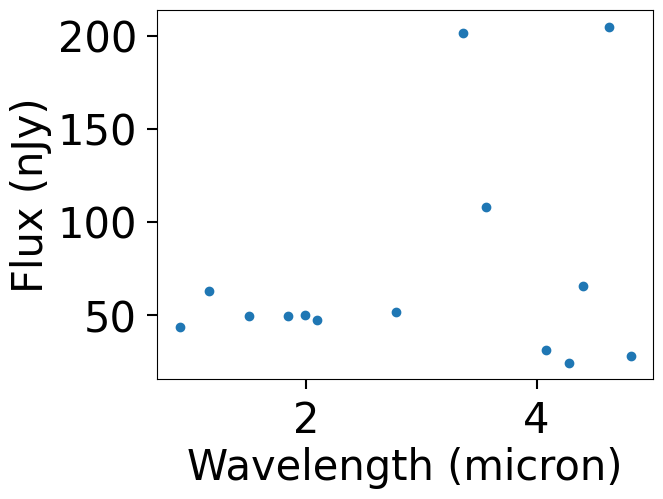

In [126]:
plt.scatter(wave_pivot_obs, photometry_data)
plt.xlabel("Wavelength (micron)")
plt.ylabel("Flux (nJy)")

In [127]:
def build_obs(snr=10, ldist=5.832e+04, **extras):
    """Build a dictionary of observational data.  In this example 
    the data consist of photometry for a single nearby dwarf galaxy 
    from Johnson et al. 2013.
    
    :param snr:
        The S/N to assign to the photometry, since none are reported 
        in Johnson et al. 2013
        
    :param ldist:
        The luminosity distance to assume for translating absolute magnitudes 
        into apparent magnitudes.
        
    :returns obs:
        A dictionary of observational data to use in the fit.
    """
    from prospect.utils.obsutils import fix_obs
    import sedpy

    # The obs dictionary, empty for now
    obs = {}


    jwst = ['jwst_{0}'.format(b) for b in ['f090w', 'f115w','f150w','f182m','f200w','f210m',
                                        'f277w', 'f335m', 'f356w', 'f410m', 'f430m',
                                        'f444w', 'f460m', 'f480m']]
    filternames = jwst
    # And here we instantiate the `Filter()` objects using methods in `sedpy`,
    # and put the resultinf list of Filter objects in the "filters" key of the `obs` dictionary
    obs["filters"] = sedpy.observate.load_filters(filternames)

    # Now we store the measured fluxes for a single object, **in the same order as "filters"**
    # In this example we use a row of absolute AB magnitudes from Johnson et al. 2013 (NGC4163)
    # We then turn them into apparent magnitudes based on the supplied `ldist` meta-parameter.
    # You could also, e.g. read from a catalog.
    # The units of the fluxes need to be maggies (Jy/3631) so we will do the conversion here too.
    m_AB = -2.5 * np.log10((photometry_data * u.nJy).to(u.Jansky)/(3631*u.Jansky))
    obs["maggies"] = 10**(-0.4*m_AB)


    # And now we store the uncertainties (again in units of maggies)
    # In this example we are going to fudge the uncertainties based on the supplied `snr` meta-parameter.
    obs["maggies_unc"] = (1./snr) * obs["maggies"]

    # Now we need a mask, which says which flux values to consider in the likelihood.
    # IMPORTANT: the mask is *True* for values that you *want* to fit, 
    # and *False* for values you want to ignore.  Here we ignore the spitzer bands.
    obs["phot_mask"] = np.array(['spitzer' not in f.name for f in obs["filters"]])

    # This is an array of effective wavelengths for each of the filters.  
    # It is not necessary, but it can be useful for plotting so we store it here as a convenience
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

    # We do not have a spectrum, so we set some required elements of the obs dictionary to None.
    # (this would be a vector of vacuum wavelengths in angstroms)
    obs["wavelength"] = None
    # (this would be the spectrum in units of maggies)
    obs["spectrum"] = None
    # (spectral uncertainties are given here)
    obs['unc'] = None
    # (again, to ignore a particular wavelength set the value of the 
    #  corresponding elemnt of the mask to *False*)
    obs['mask'] = None

    # This function ensures all required keys are present in the obs dictionary,
    # adding default values if necessary
    obs = fix_obs(obs)

    return obs

In [128]:
from prospect.utils.obsutils import fix_obs
import sedpy

# The obs dictionary, empty for now
obs = {}

# These are the names of the relevant filters, 
# in the same order as the photometric data (see below)
jwst = ['jwst_{0}'.format(b) for b in ['f090w', 'f115w','f150w','f182m','f200w','f210m',
                                    'f277w', 'f335m', 'f356w', 'f410m', 'f430m',
                                    'f444w', 'f460m', 'f480m']]
filternames = jwst
# And here we instantiate the `Filter()` objects using methods in `sedpy`,
# and put the resultinf list of Filter objects in the "filters" key of the `obs` dictionary
obs["filters"] = sedpy.observate.load_filters(filternames)

# Now we store the measured fluxes for a single object, **in the same order as "filters"**
# In this example we use a row of absolute AB magnitudes from Johnson et al. 2013 (NGC4163)
# We then turn them into apparent magnitudes based on the supplied `ldist` meta-parameter.
# You could also, e.g. read from a catalog.
# The units of the fluxes need to be maggies (Jy/3631) so we will do the conversion here too.
m_AB = -2.5 * np.log10((photometry_data * u.nJy).to(u.Jansky)/(3631*u.Jansky))
obs["maggies"] = 10**(-0.4*m_AB)

# And now we store the uncertainties (again in units of maggies)
# In this example we are going to fudge the uncertainties based on the supplied `snr` meta-parameter.
obs["maggies_unc"] = (1./10.0) * obs["maggies"]

# Now we need a mask, which says which flux values to consider in the likelihood.
# IMPORTANT: the mask is *True* for values that you *want* to fit, 
# and *False* for values you want to ignore.  Here we ignore the spitzer bands.
obs["phot_mask"] = np.array(['spitzer' not in f.name for f in obs["filters"]])

# This is an array of effective wavelengths for each of the filters.  
# It is not necessary, but it can be useful for plotting so we store it here as a convenience
obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

# We do not have a spectrum, so we set some required elements of the obs dictionary to None.
# (this would be a vector of vacuum wavelengths in angstroms)
obs["wavelength"] = None
# (this would be the spectrum in units of maggies)
obs["spectrum"] = None
# (spectral uncertainties are given here)
obs['unc'] = None
# (again, to ignore a particular wavelength set the value of the 
#  corresponding elemnt of the mask to *False*)
obs['mask'] = None

obs = fix_obs(obs)


In [129]:
run_params = {}
run_params["snr"] = 10.0
run_params["ldist"] = 5.832e+04

Obs Dictionary Keys:

dict_keys(['filters', 'maggies', 'maggies_unc', 'phot_mask', 'phot_wave', 'wavelength', 'spectrum', 'unc', 'mask', 'filternames', 'logify_spectrum', 'ndof'])

--------
Filter objects:

[<class 'sedpy.observate.Filter'>(jwst_f090w), <class 'sedpy.observate.Filter'>(jwst_f115w), <class 'sedpy.observate.Filter'>(jwst_f150w), <class 'sedpy.observate.Filter'>(jwst_f182m), <class 'sedpy.observate.Filter'>(jwst_f200w), <class 'sedpy.observate.Filter'>(jwst_f210m), <class 'sedpy.observate.Filter'>(jwst_f277w), <class 'sedpy.observate.Filter'>(jwst_f335m), <class 'sedpy.observate.Filter'>(jwst_f356w), <class 'sedpy.observate.Filter'>(jwst_f410m), <class 'sedpy.observate.Filter'>(jwst_f430m), <class 'sedpy.observate.Filter'>(jwst_f444w), <class 'sedpy.observate.Filter'>(jwst_f460m), <class 'sedpy.observate.Filter'>(jwst_f480m)]


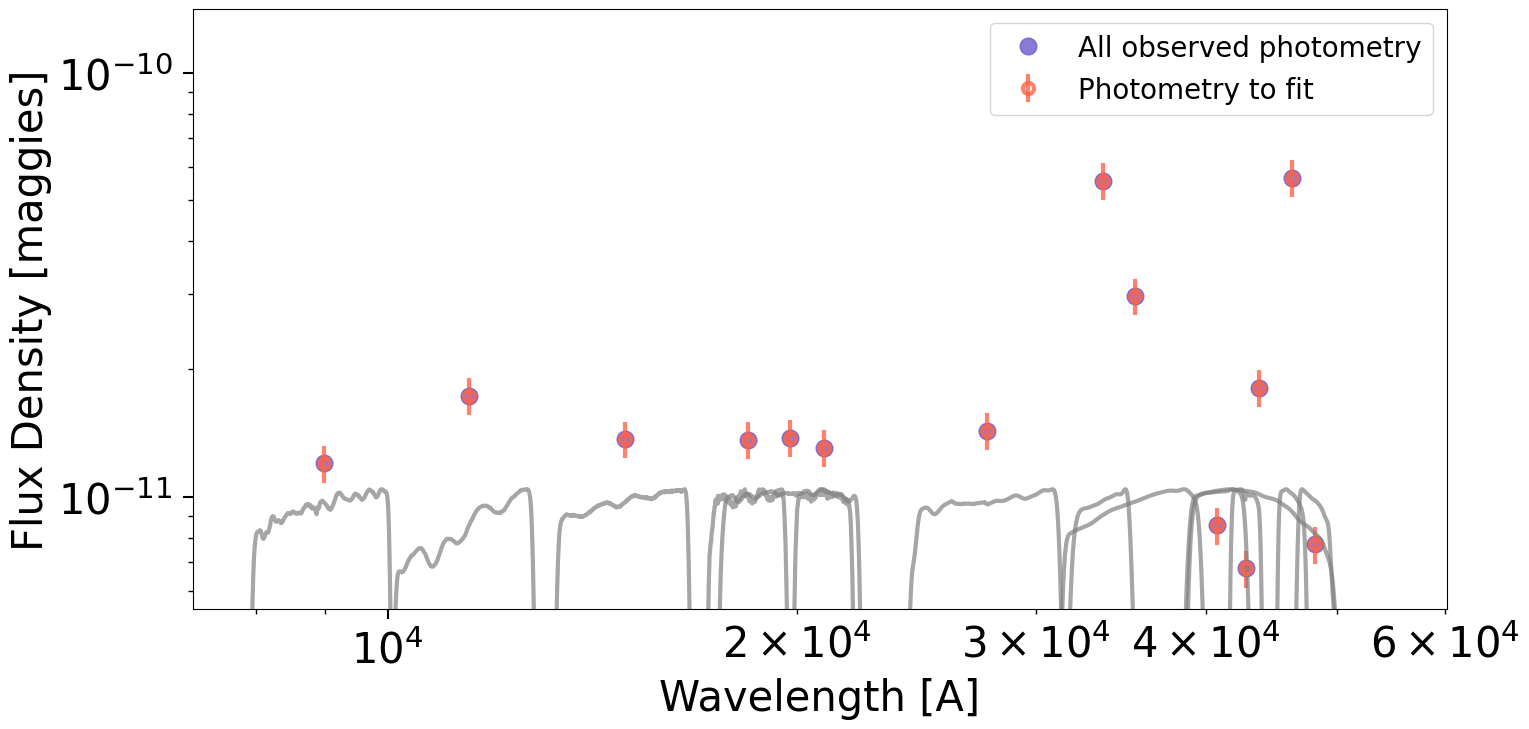

In [130]:
# Build the obs dictionary using the meta-parameters
obs = build_obs(**run_params)

# Look at the contents of the obs dictionary
print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
print("--------\nFilter objects:\n")
print(obs["filters"])

# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
figure(figsize=(16,8))

# plot all the data
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# overplot only the data we intend to fit
mask = obs["phot_mask"]
errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
tight_layout()

In [131]:
from prospect.models import priors
mass_param = {"name": "mass",
              # The mass parameter here is a scalar, so it has N=1
              "N": 1,
              # We will be fitting for the mass, so it is a free parameter
              "isfree": True,
              # This is the initial value. For fixed parameters this is the
              # value that will always be used. 
              "init": 1e8,
              # This sets the prior probability for the parameter
              "prior": priors.LogUniform(mini=1e6, maxi=1e12),
              # this sets the initial dispersion to use when generating 
              # clouds of emcee "walkers".  It is not required, but can be very helpful.
              "init_disp": 1e6, 
              # this sets the minimum dispersion to use when generating 
              #clouds of emcee "walkers".  It is not required, but can be useful if 
              # burn-in rounds leave the walker distribution too narrow for some reason.
              "disp_floor": 1e6, 
              # This is not required, but can be helpful
              "units": "solar masses formed",
              }

In [132]:
from prospect.models.templates import TemplateLibrary

# Look at all the prepackaged parameter sets
TemplateLibrary.show_contents()

'type_defaults':
  Explicitly sets dust amd IMF types.
'ssp':
  Basic set of (free) parameters for a delta function SFH
'parametric_sfh':
  Basic set of (free) parameters for a delay-tau SFH.
'dust_emission':
  The set of (fixed) dust emission parameters.
'nebular':
  The set of nebular emission parameters, with gas_logz tied to stellar logzsol.
'nebular_marginalization':
  Marginalize over emission amplitudes line contained inthe observed spectrum
'fit_eline_redshift':
  Fit for the redshift of the emission lines separatelyfrom the stellar redshift
'agn_eline':
  Add AGN emission lines
'outlier_model':
  The set of outlier (mixture) models for spectroscopy and photometry
'agn':
  The set of (fixed) AGN dusty torus emission parameters.
'igm':
  The set of (fixed) IGM absorption parameters.
'spectral_smoothing':
  Set of parameters for spectal smoothing.
'optimize_speccal':
  Set of parameters (most of which are fixed) for optimizing a polynomial calibration vector.
'fit_speccal':
  Set

In [133]:
TemplateLibrary.describe("parametric_sfh")

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: 0.1 
  sfh: 4 
  imf_type: 2 
  dust_type: 0 


In [134]:
def build_model(object_redshift=None, ldist=5.832e+04, fixed_metallicity=None, add_duste=False, 
                **extras):
    """Build a prospect.models.SedModel object
    
    :param object_redshift: (optional, default: None)
        If given, produce spectra and observed frame photometry appropriate 
        for this redshift. Otherwise, the redshift will be zero.
        
    :param ldist: (optional, default: 10)
        The luminosity distance (in Mpc) for the model.  Spectra and observed 
        frame (apparent) photometry will be appropriate for this luminosity distance.
        
    :param fixed_metallicity: (optional, default: None)
        If given, fix the model metallicity (:math:`log(Z/Z_sun)`) to the given value.
        
    :param add_duste: (optional, default: False)
        If `True`, add dust emission and associated (fixed) parameters to the model.
        
    :returns model:
        An instance of prospect.models.SedModel
    """
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors

    # Get (a copy of) one of the prepackaged model set dictionaries.
    # This is, somewhat confusingly, a dictionary of dictionaries, keyed by parameter name
    model_params = TemplateLibrary["parametric_sfh"]
    
   # Now add the lumdist parameter by hand as another entry in the dictionary.
   # This will control the distance since we are setting the redshift to zero.  
   # In `build_obs` above we used a distance of 10Mpc to convert from absolute to apparent magnitudes, 
   # so we use that here too, since the `maggies` are appropriate for that distance.
    model_params["lumdist"] = {"N": 1, "isfree": False, "init": ldist, "units":"Mpc"}
    
    # Let's make some changes to initial values appropriate for our objects and data
    model_params["zred"]["init"] = 0.0
    model_params["dust2"]["init"] = 0.05
    model_params["logzsol"]["init"] = -0.5
    model_params["tage"]["init"] = 13.
    model_params["mass"]["init"] = 1e8
    
    # These are dwarf galaxies, so lets also adjust the metallicity prior,
    # the tau parameter upward, and the mass prior downward
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
    model_params["tau"]["prior"] = priors.LogUniform(mini=1e-1, maxi=1e2)
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e6, maxi=1e10)

    # If we are going to be using emcee, it is useful to provide a 
    # minimum scale for the cloud of walkers (the default is 0.1)
    model_params["mass"]["disp_floor"] = 1e6
    model_params["tau"]["disp_floor"] = 1.0
    model_params["tage"]["disp_floor"] = 1.0
    
    # Change the model parameter specifications based on some keyword arguments
    if fixed_metallicity is not None:
        # make it a fixed parameter
        model_params["logzsol"]["isfree"] = False
        #And use value supplied by fixed_metallicity keyword
        model_params["logzsol"]['init'] = fixed_metallicity 

    if object_redshift is not None:
        # make sure zred is fixed
        model_params["zred"]['isfree'] = False
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = object_redshift

    if add_duste:
        # Add dust emission (with fixed dust SED parameters)
        # Since `model_params` is a dictionary of parameter specifications, 
        # and `TemplateLibrary` returns dictionaries of parameter specifications, 
        # we can just update `model_params` with the parameters described in the 
        # pre-packaged `dust_emission` parameter set.
        model_params.update(TemplateLibrary["dust_emission"])
        
    # Now instantiate the model object using this dictionary of parameter specifications
    model = SedModel(model_params)

    return model


run_params["object_redshift"] = 0.0
run_params["fixed_metallicity"] = None
run_params["add_duste"] = True

In [135]:
model = build_model(**run_params)
print(model)
print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
print("Initial parameter dictionary:\n{}".format(model.params))

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=1000000.0,maxi=10000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=100.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [0] 
  lumdist: [58320.] 
  add_dust_emission: [ True] 
  duste_umin: [1.] 
  duste_qpah: [4.] 
  duste_gamma: [0.001] 

Initial free parameter vector theta:
  [ 1.0e+08 -5.0e-01  5.0e-02  1.3e+01  1.0e+00]

Initial parameter dictionary:
{'zred': array([0.]), 'mass': array([1.e+08]), 'logzsol': array([-0.5]), 'dust2': array([0.05]), 'sfh': array([4]), 'tage': array([13.]), 'imf_type': array([2]), 'dust_type': array(

In [136]:
def build_sps(zcontinuous=1, **extras):
    """
    :param zcontinuous: 
        A vlue of 1 insures that we use interpolation between SSPs to 
        have a continuous metallicity parameter (`logzsol`)
        See python-FSPS documentation for details
    """
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

run_params["zcontinuous"] = 1

In [137]:
sps = build_sps(**run_params)
help(sps.get_spectrum)

Help on method get_spectrum in module prospect.sources.ssp_basis:

get_spectrum(outwave=None, filters=None, peraa=False, **params) method of prospect.sources.galaxy_basis.CSPSpecBasis instance
    Get a spectrum and SED for the given params.
    
    :param outwave: (default: None)
        Desired *vacuum* wavelengths.  Defaults to the values in
        ``sps.wavelength``.
    
    :param peraa: (default: False)
        If `True`, return the spectrum in erg/s/cm^2/AA instead of AB
        maggies.
    
    :param filters: (default: None)
        A list of filter objects for which you'd like photometry to be calculated.
    
    :param params:
        Optional keywords giving parameter values that will be used to
        generate the predicted spectrum.
    
    :returns spec:
        Observed frame spectrum in AB maggies, unless ``peraa=True`` in which
        case the units are erg/s/cm^2/AA.
    
    :returns phot:
        Observed frame photometry in AB maggies.
    
    :returns ma

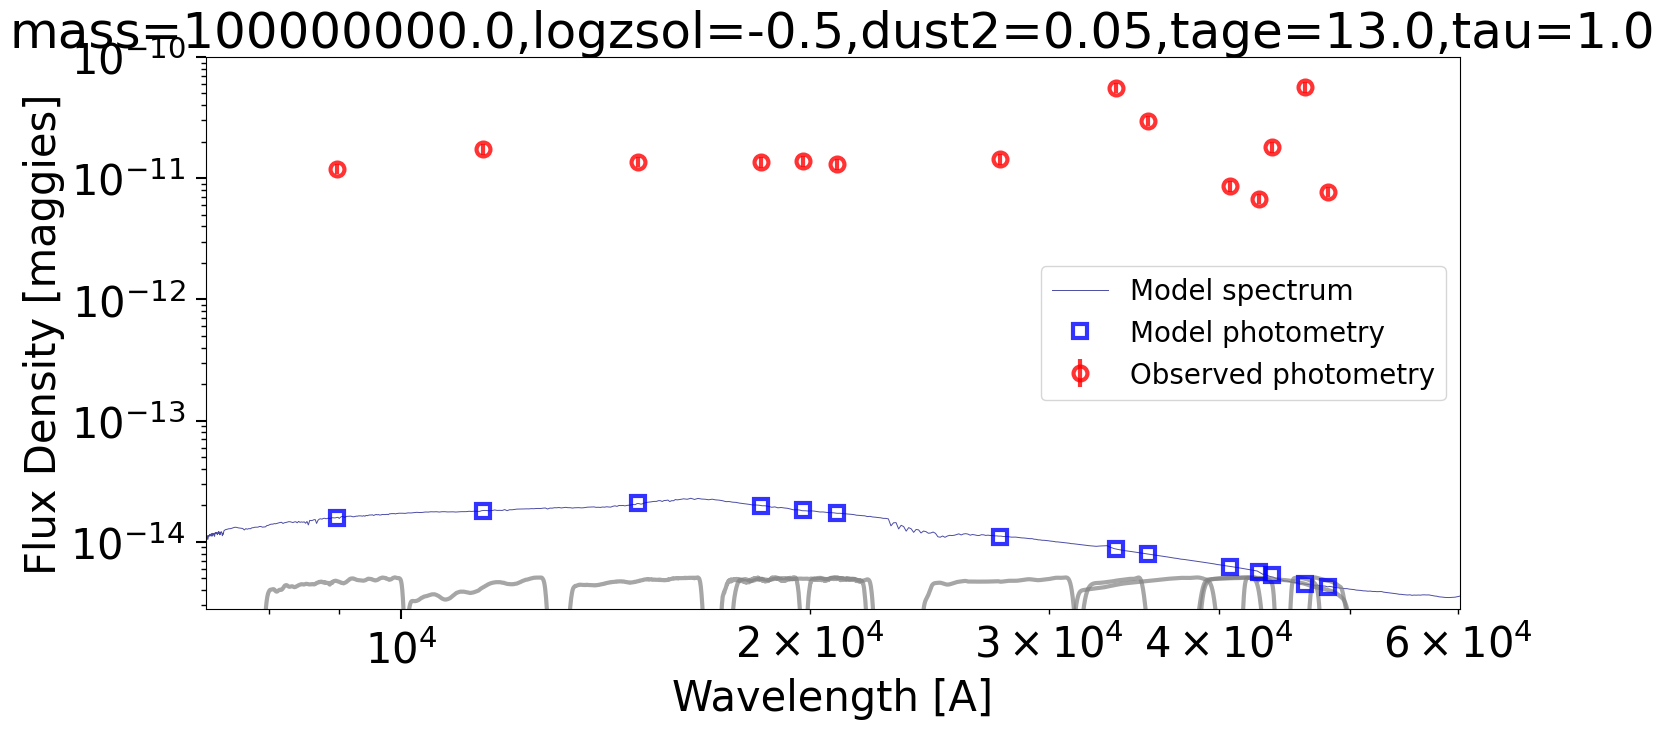

In [138]:
# Generate the model SED at the initial value of theta
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, 1e-10])
legend(loc='best', fontsize=20)
tight_layout()


In [139]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

verbose = False
def lnprobfn(theta, model=None, obs=None, sps=None, 
             nested=False, verbose=verbose):
    """
    Given a parameter vector, a model, a dictionary of observational 
    data, and an sps object, return the ln of the posterior. 
    """

    # Calculate prior probability and exit if not within prior
    # Also if doing nested sampling, do not include the basic priors, 
    # since the drawing method includes the prior probability
    lnp_prior = model.prior_product(theta, nested=nested)
    if not np.isfinite(lnp_prior):
        return -np.inf
        
    # Generate "mean" model
    spec, phot, mfrac = model.mean_model(theta, obs, sps=sps)
 
    # Calculate likelihoods
    lnp_spec = lnlike_spec(spec, obs=obs)
    lnp_phot = lnlike_phot(phot, obs=obs)

    return lnp_prior + lnp_phot + lnp_spec

run_params["verbose"] = verbose

In [140]:
from prospect.likelihood import chi_spec, chi_phot
def chivecfn(theta):
    """A version of lnprobfn that returns the simple uncertainty 
    normalized residual instead of the log-posterior, for use with 
    least-squares optimization methods like Levenburg-Marquardt.
    
    It's important to note that the returned chi vector does not 
    include the prior probability.
    """
    lnp_prior = model.prior_product(theta)
    if not np.isfinite(lnp_prior):
        return np.zeros(model.ndim) - np.inf

    # Generate mean model
    try:
        spec, phot, x = model.mean_model(theta, obs, sps=sps)
    except(ValueError):
        return np.zeros(model.ndim) - np.inf

    chispec = chi_spec(spec, obs)
    chiphot = chi_phot(phot, obs)
    return np.concatenate([chispec, chiphot])

In [141]:
from prospect.fitting import lnprobfn
help(lnprobfn)

Help on function lnprobfn in module prospect.fitting.fitting:

lnprobfn(theta, model=None, obs=None, sps=None, noise=(None, None), residuals=False, nested=False, negative=False, verbose=False)
    Given a parameter vector and optionally a dictionary of observational
    ata and a model object, return the matural log of the posterior. This
    requires that an sps object (and if using spectra and gaussian processes, a
    NoiseModel) be instantiated.
    
    :param theta:
        Input parameter vector, ndarray of shape (ndim,)
    
    :param model:
        SedModel model object, with attributes including ``params``, a
        dictionary of model parameter state.  It must also have
        :py:func:`prior_product`, and :py:func:`predict` methods
        defined.
    
    :param obs:
        A dictionary of observational data.  The keys should be
    
        + ``"wavelength"``  (angstroms)
        + ``"spectrum"``    (maggies)
        + ``"unc"``         (maggies)
        + ``"maggies

In [142]:
# Here we will run all our building functions
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

# For fsps based sources it is useful to 
# know which stellar isochrone and spectral library
# we are using
print(sps.ssp.libraries)

(b'mist', b'miles', b'DL07')


In [143]:
from prospect.fitting import fit_model
help(fit_model)

Help on function fit_model in module prospect.fitting.fitting:

fit_model(obs, model, sps, noise=(None, None), lnprobfn=<function lnprobfn at 0x7672e4d235b0>, optimize=False, emcee=False, dynesty=True, **kwargs)
    Fit a model to observations using a number of different methods
    
    :param obs:
        The ``obs`` dictionary containing the data to fit to, which will be
        passed to ``lnprobfn``.
    
    :param model:
        An instance of the :py:class:`prospect.models.SedModel` class
        containing the model parameterization and parameter state.  It will be
        passed to ``lnprobfn``.
    
    :param sps:
        An instance of a :py:class:`prospect.sources.SSPBasis` (sub-)class.
        Alternatively, anything with a compatible :py:func:`get_spectrum` can
        be used here. It will be passed to ``lnprobfn``
    
    :param noise: (optional, default: (None, None))
        A tuple of NoiseModel objects for the spectroscopy and photometry
        respectively.  Ca

In [144]:
# --- start minimization ----
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# We'll start minimization from "nmin" separate places, 
# the first based on the current values of each parameter and the 
# rest drawn from the prior.  Starting from these extra draws 
# can guard against local minima, or problems caused by 
# starting at the edge of a prior (e.g. dust2=0.0)
run_params["nmin"] = 2

output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)

print("Done optmization in {}s".format(output["optimization"][1]))

Done optmization in 76.34339809417725s


[6.47162340e+07 9.47226440e-02 4.74055077e-07 3.75532599e+00
 9.38474263e-01]
1
[6.47162340e+07 9.47226440e-02 4.74055077e-07 3.75532599e+00
 9.38474263e-01]


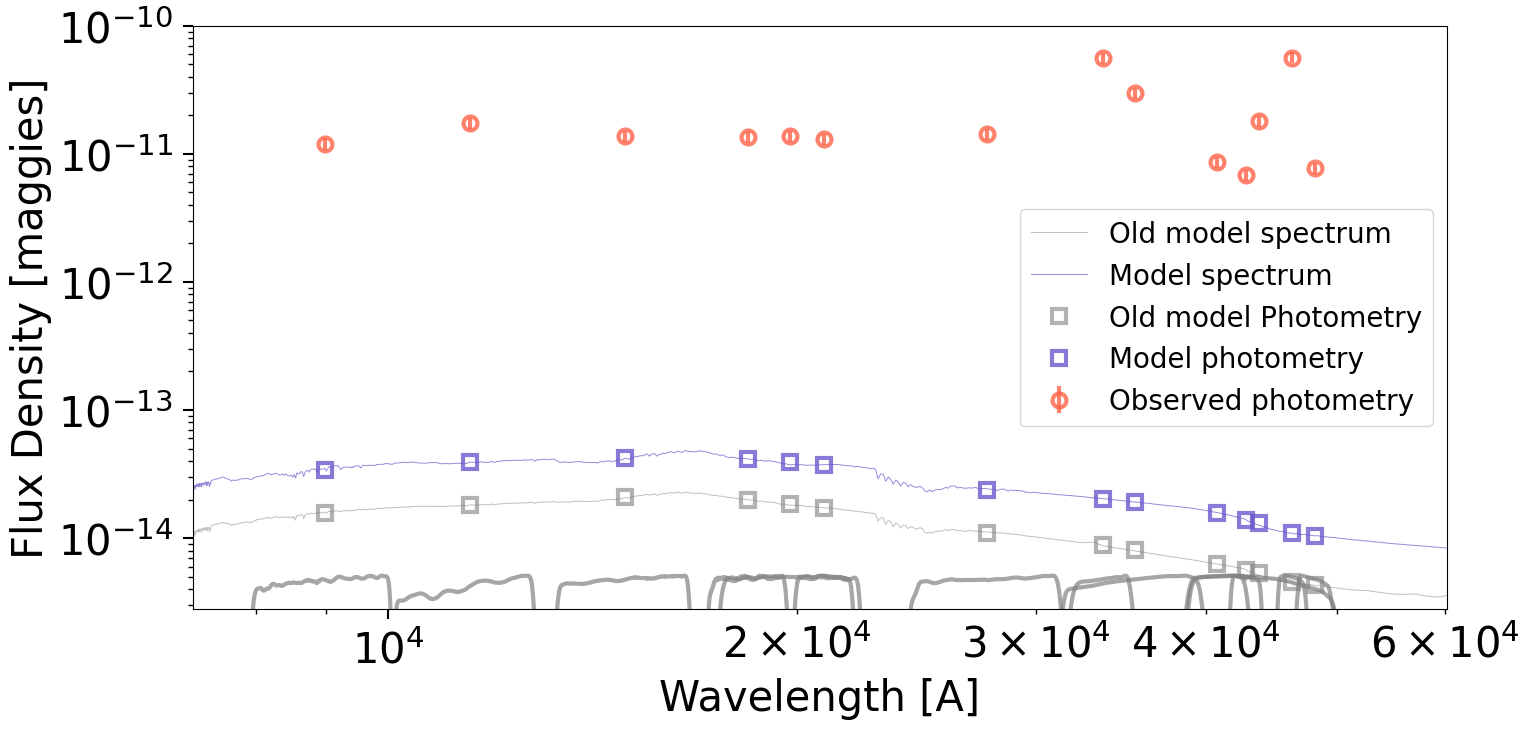

In [145]:
print(model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print(ind_best)
theta_best = results[ind_best].x.copy()
print(theta_best)

# generate model
prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

figure(figsize=(16,8))

# plot Data, best fit model, and old models
loglog(wspec, initial_spec, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
         marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)
loglog(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='slateblue', alpha=0.7)
errorbar(wphot, pphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='slateblue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, 1e-10])
legend(loc='best', fontsize=20)
tight_layout()

In [146]:
# Set this to False if you don't want to do another optimization
# before emcee sampling (but note that the "optimization" entry 
# in the output dictionary will be (None, 0.) in this case)
# If set to true then another round of optmization will be performed 
# before sampling begins and the "optmization" entry of the output
# will be populated.
run_params["optimize"] = False
run_params["emcee"] = True
run_params["dynesty"] = False
# Number of emcee walkers
run_params["nwalkers"] = 128
# Number of iterations of the MCMC sampling
run_params["niter"] = 512
# Number of iterations in each round of burn-in
# After each round, the walkers are reinitialized based on the 
# locations of the highest probablity half of the walkers.
run_params["nburn"] = [16, 32, 64]

In [147]:
import prospect
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done emcee in {0}s'.format(output["sampling"][1]))

done emcee in 194.41093468666077s


In [148]:
from prospect.io import write_results as writer
hfile = "GS9422_emcee_mcmc.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

Finished


In [149]:
run_params["dynesty"] = True
run_params["optmization"] = False
run_params["emcee"] = False
run_params["nested_method"] = "rwalk"
run_params["nlive_init"] = 400
run_params["nlive_batch"] = 200
run_params["nested_dlogz_init"] = 0.05
run_params["nested_posterior_thresh"] = 0.05
run_params["nested_maxcall"] = int(1e7)

In [150]:
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done dynesty in {0}s'.format(output["sampling"][1]))

iter: 14522 | batch: 27 | nc: 1 | ncall: 160667 | eff(%):  7.484 | loglstar: 267.026 < 269.776 < 269.024 | logz: 258.643 +/-  0.096 | stop:  1.012      

done dynesty in 544.8556773662567s


In [151]:
from prospect.io import write_results as writer
hfile = "GS9422_dynesty_mcmc.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

Finished


/home/cal/fabg/.local/lib/python3.10/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/home/cal/fabg/.local/lib/python3.10/site-packages/prospect/io/write_results.py:301: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/home/cal/fabg/.local/lib/python3.10/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


In [152]:
from prospect import prospect_args
# - Parser with default arguments -
parser = prospect_args.get_parser()
# - Add custom arguments -
parser.add_argument('--add_duste', action="store_true",
                    help="If set, add dust emission to the model.")
parser.add_argument('--ldist', type=float, default=10,
                    help=("Luminosity distance in Mpc. Defaults to 10"
                          "(for case of absolute mags)"))
args, _ = parser.parse_known_args()
cli_run_params = vars(args)
print(cli_run_params)

{'verbose': 1, 'debug': False, 'outfile': 'prospector_test_run', 'output_pickle': False, 'zcontinuous': 1, 'optimize': False, 'min_method': 'lm', 'min_opts': {}, 'nmin': 1, 'emcee': False, 'nwalkers': 64, 'niter': 512, 'nburn': [16, 32, 64], 'interval': 0.2, 'restart_from': '', 'initial_disp': 0.1, 'dynesty': False, 'nested_bound': 'multi', 'nested_sample': 'slice', 'nested_walks': 48, 'nested_nlive_init': 100, 'nested_nlive_batch': 100, 'nested_dlogz_init': 0.05, 'nested_maxcall': 50000000, 'nested_maxiter': 1000000, 'nested_maxbatch': 10, 'nested_bootstrap': 0, 'nested_target_n_effective': 10000, 'add_duste': False, 'ldist': 10}


In [153]:
import prospect.io.read_results as reader
results_type = "emcee" # | "dynesty"
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
result, obs, _ = reader.results_from("GS9422_{}_mcmc.h5".format(results_type), dangerous=False)

#The following commented lines reconstruct the model and sps object, 
# if a parameter file continaing the `build_*` methods was saved along with the results
#model = reader.get_model(result)
#sps = reader.get_sps(result)

# let's look at what's stored in the `result` dictionary
print(result.keys())

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'acceptance', 'chain', 'initial_theta', 'lnprobability', 'sampling_initial_center', 'rstate', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])


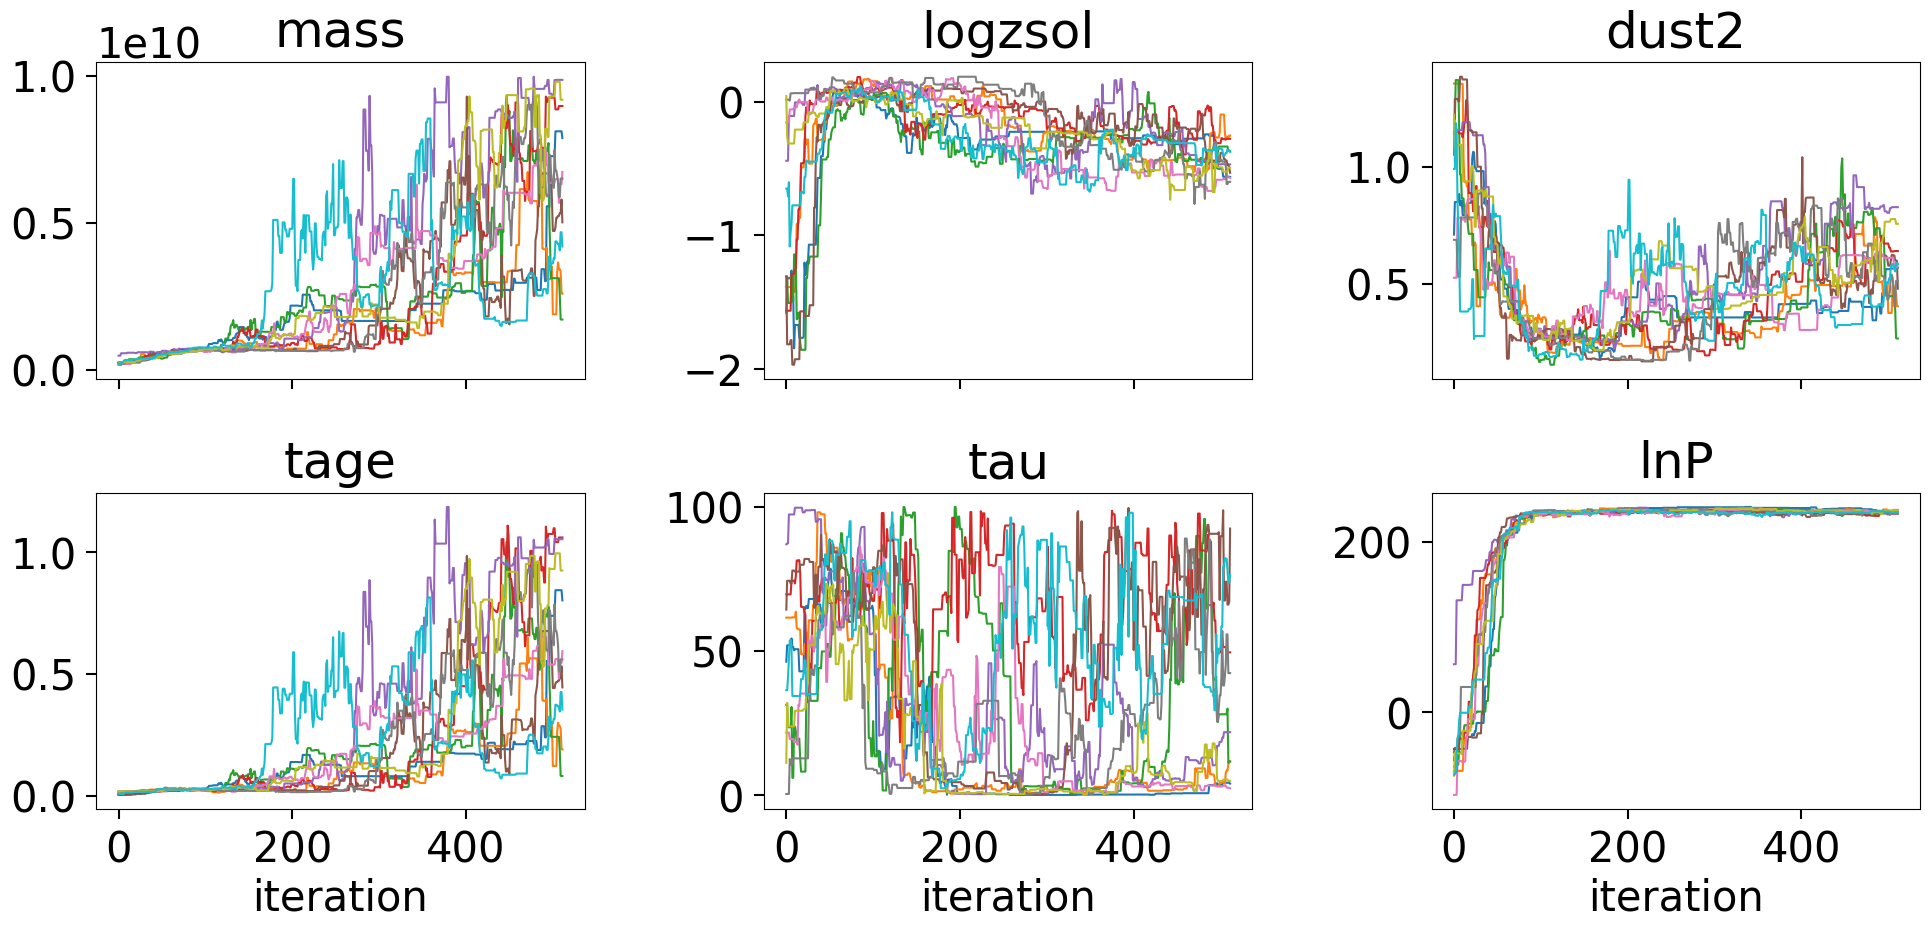

In [154]:
if results_type == "emcee":
    chosen = np.random.choice(result["run_params"]["nwalkers"], size=10, replace=False)
    tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)
else:
    tracefig = reader.traceplot(result, figsize=(20,10))


Optimization value: [6.47162340e+07 9.47226440e-02 4.74055077e-07 3.75532599e+00
 9.38474263e-01]
MAP value: [6.87224428e+08 3.13997794e-02 2.12864528e-01 2.31743687e-02
 1.53153297e-01]


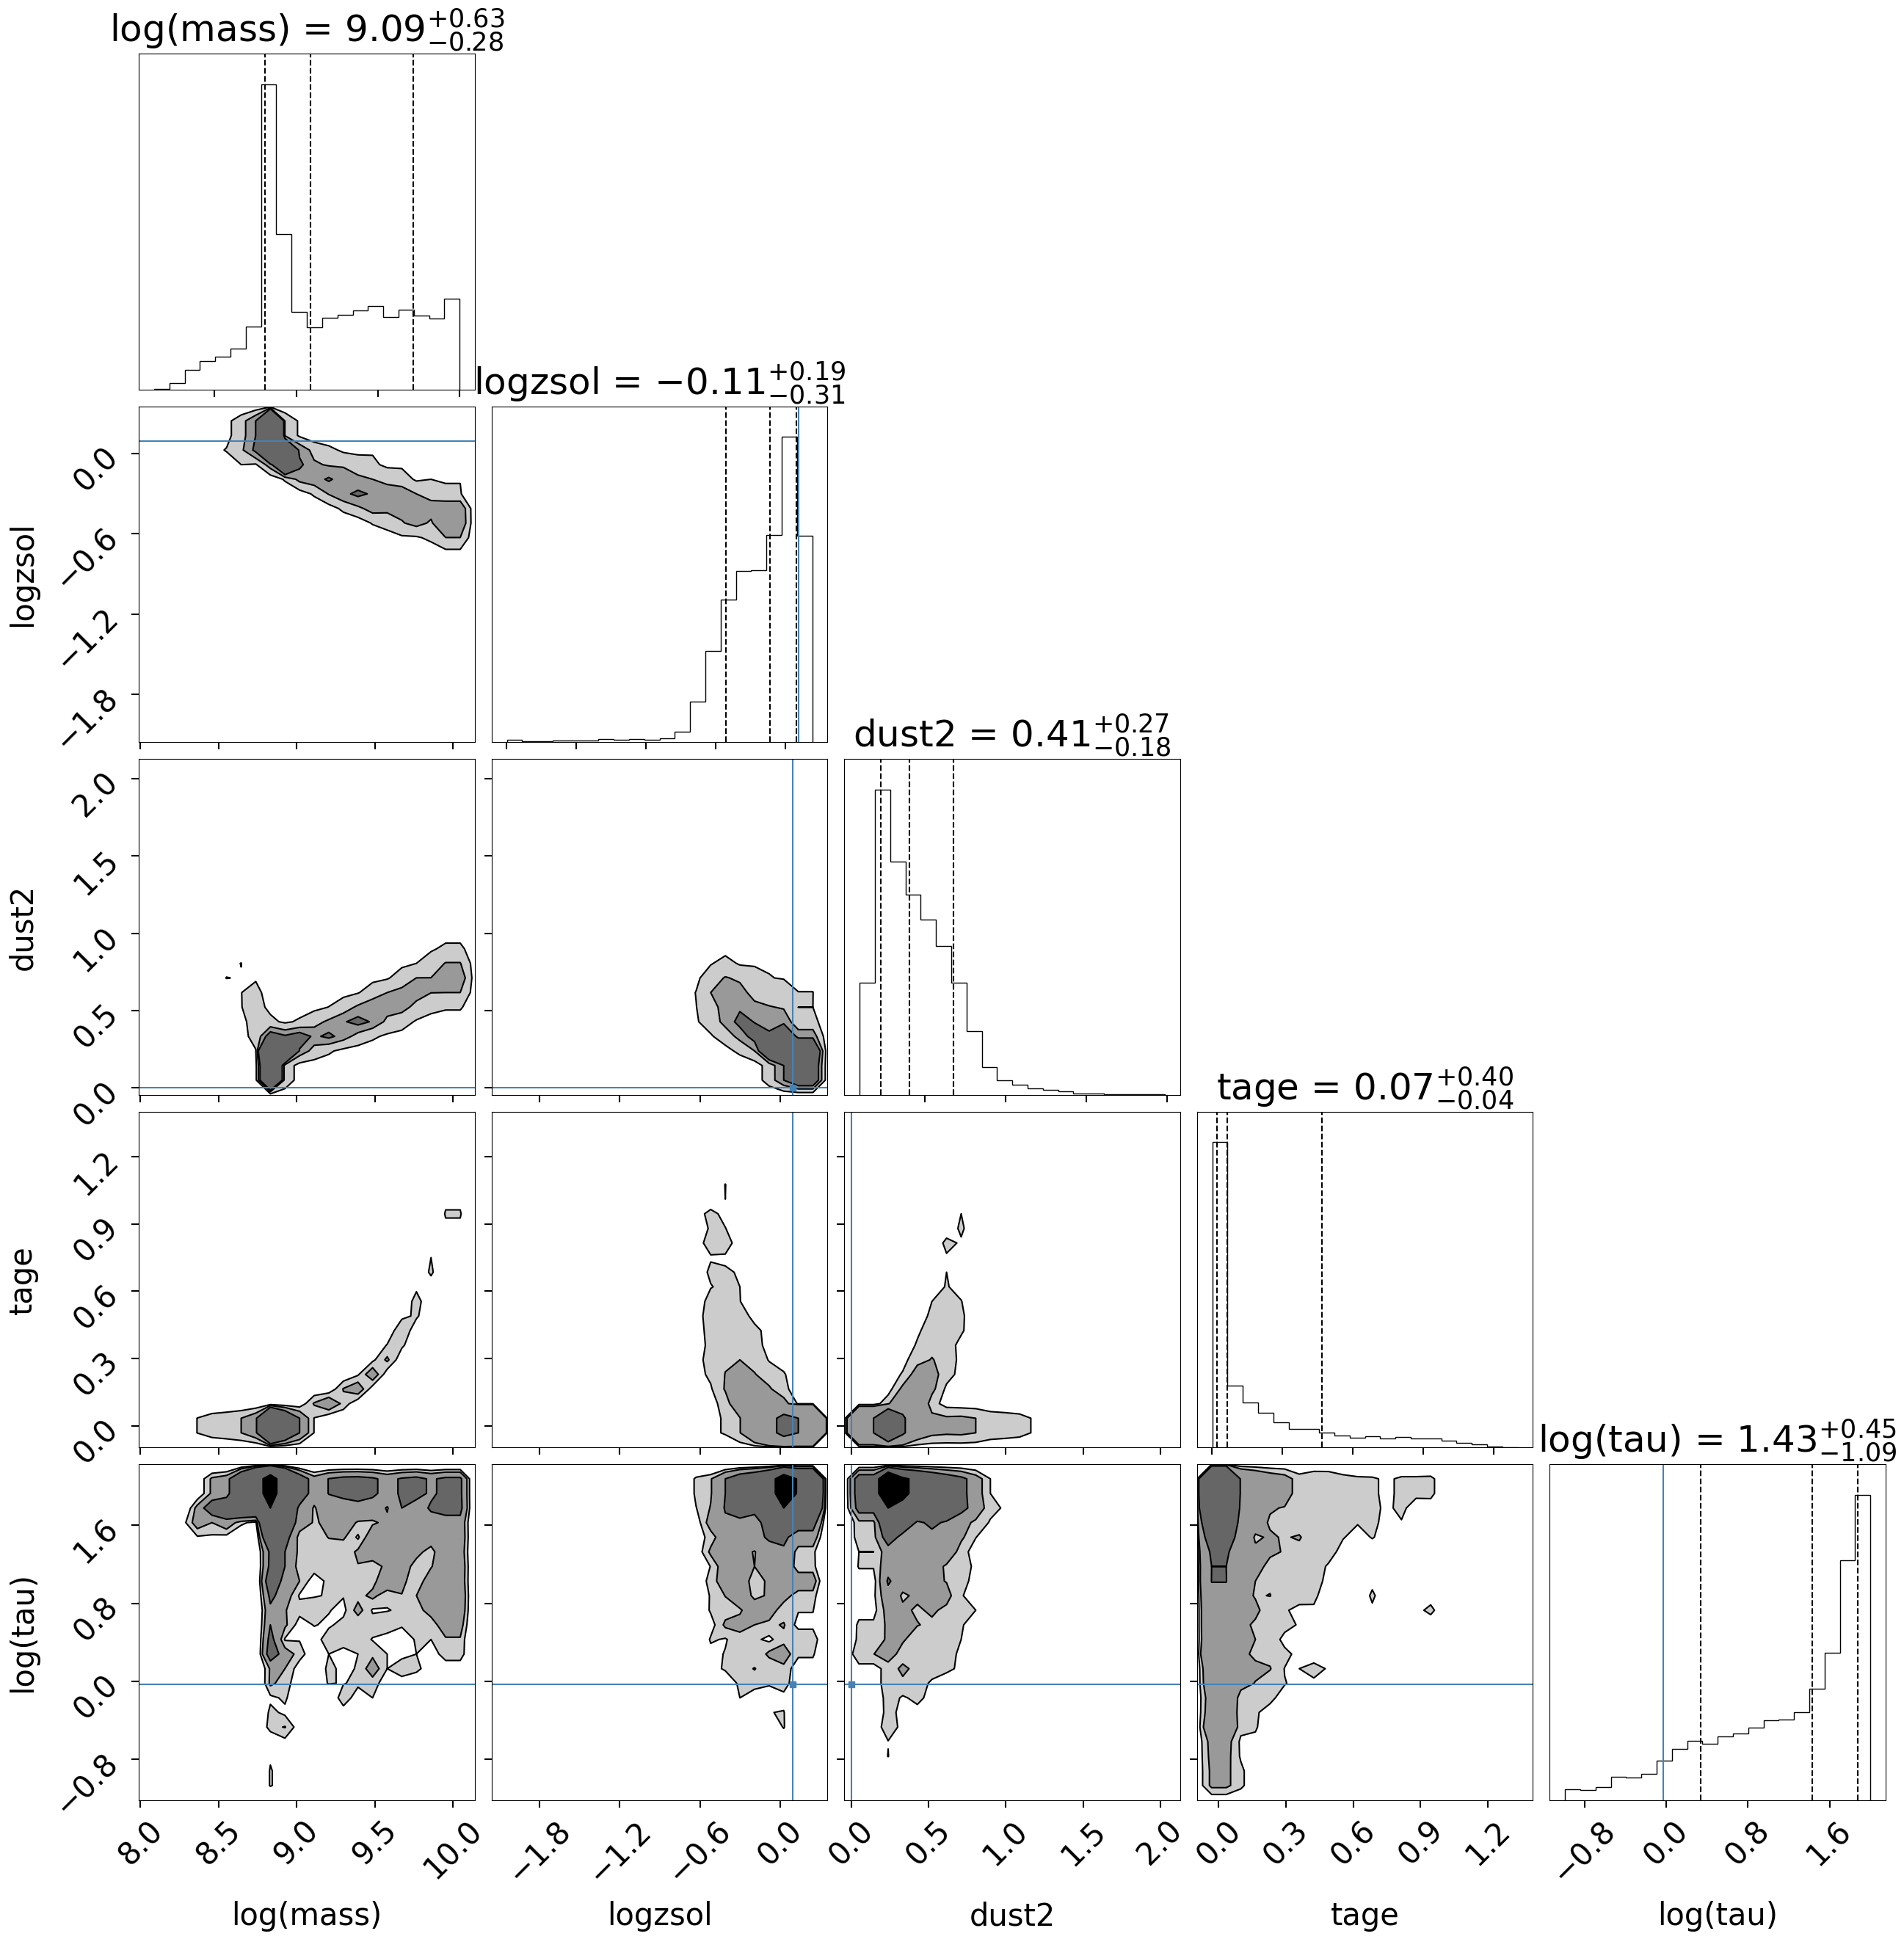

In [155]:
# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = result["chain"][imax, :]
    thin = 1

print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_max))
cornerfig = reader.subcorner(result, start=0, thin=thin, truths=theta_best, 
                             fig=subplots(5,5,figsize=(27,27))[0])

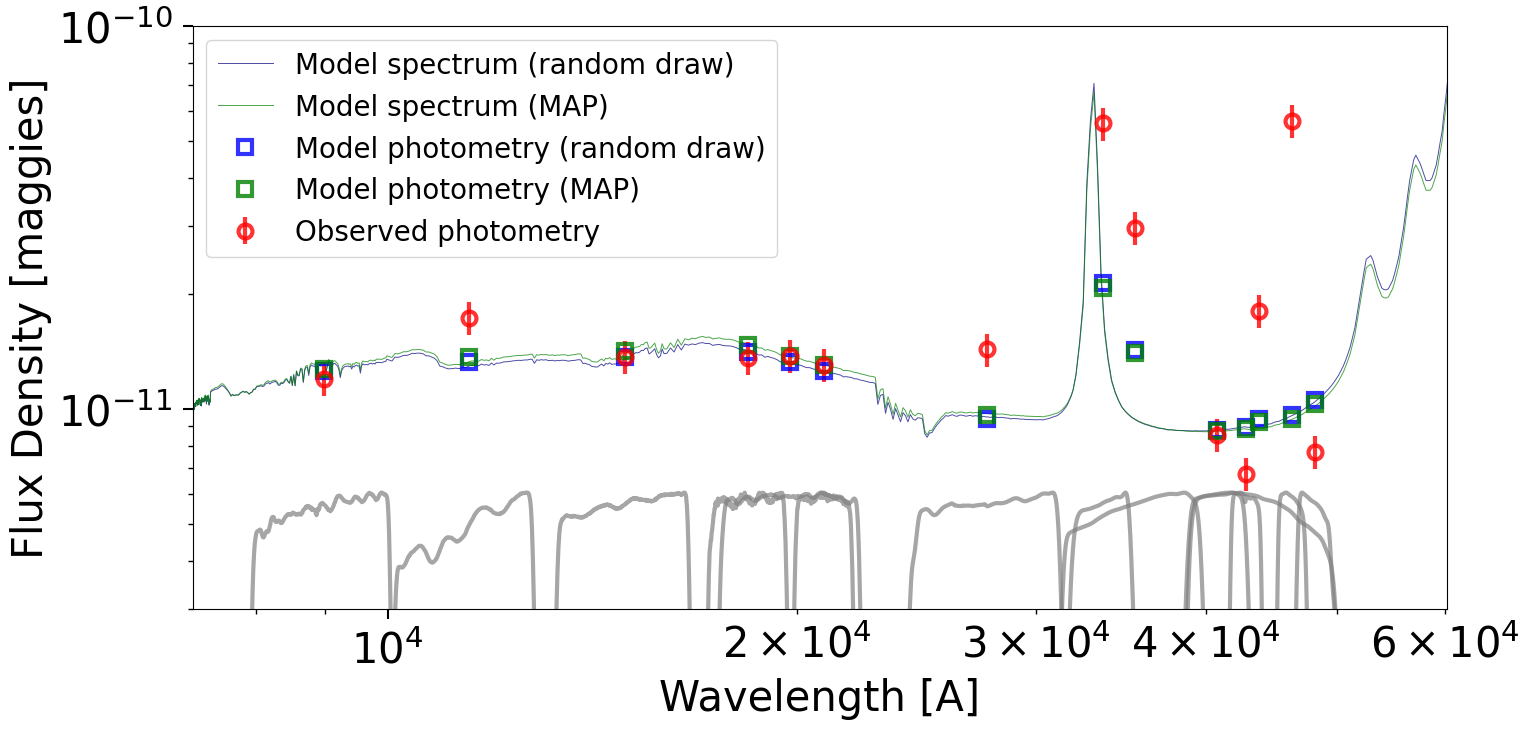

In [171]:
# randomly chosen parameters from chain
randint = np.random.randint
if results_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = result['chain'][randint(nwalkers), randint(niter)]
else:
    theta = result["chain"][randint(len(result["chain"]))]

# generate models
# sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
figure(figsize=(16,8))

loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

ymax = 1e-10
ymin = 3e-12

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

In [157]:
fix_obs

<function prospect.utils.obsutils.fix_obs(obs, rescale_spectrum=False, normalize_spectrum=False, logify_spectrum=False, grid_filters=False, **kwargs)>